```mermaid
graph TD
a(三元阵列数据)--线性预测虚拟阵元在三阵元间补阵元, 减小阵元间距--> b(阵元间距小于半波长/宽带互谱最大距离的N元阵列数据)
b--stft-->c(时频图)--相位信息-->d(有注意力的时相图)-->h(lstm)-->i(距离, 角度)
c--幅度信息-->f(给出注意力, 聚焦有脉冲的部分)-->d
```

宽带信号互谱法要求$d\le \frac{c}{2B}$, 当带宽B=500Hz, d_max = 1.5m

In [5]:
import os

os.environ['WANDB_NOTEBOOK_NAME'] = os.path.abspath('.') + '/wideband_cpsd_cnn.ipynb'
import numpy as np
import torch
import torchmetrics
import wandb
from matplotlib import pyplot as plt
from scipy import signal
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchkeras import KerasModel
from torchmetrics import Accuracy

import Datasets
import feature_modules

## 数据准备

### 数据处理

先分批将每个样本中数据按时间窗转为频相图, 作为特征

In [6]:
c = 1500
fc = 42500
fs_factor = 8
fs = fs_factor * fc
d = 0.5
K = 1.0
SNR = 'ideal'
dist_max = d * (K + 1)
maxlag = int(np.ceil(dist_max / c * fs))  # 当前采样频率下最大滞后量
sample_interval = 1

dataset_path = f'/run/media/leo/HP P900/dataset/fc_{fc}-fs_factor_{fs_factor}-d_{d}-K_{K}-SNR_{SNR}'
train_path = f'{dataset_path}/train'
val_path = f'{dataset_path}/val'

In [7]:
def process_data(feature):
    spectrogram_layer = feature_modules.Spectrogram(fs, 8192).to('cuda')
    cpsd_phase_layer = feature_modules.CPSD_Phase_Spectrogram().to('cuda')

    for folder_path in [train_path, val_path]:
        if not os.path.exists(f'{folder_path}_{feature}'):
            os.makedirs(f'{folder_path}_{feature}')
        batch_size = 50
        dl = DataLoader(Datasets.Array_Data_DataSet(folder_path), batch_size=batch_size, shuffle=False, num_workers=8, drop_last=False)
        print('batch ', end='')
        for batch, (data_segments_batch, fs_batch, r_n_batch, angle_n_batch, filename_batch) in enumerate(dl):
            phase_batch = cpsd_phase_layer(spectrogram_layer(data_segments_batch.to('cuda'))).cpu().detach().numpy().astype(np.float32)  # shape: (batch_size, 3, freq_limited, time)
            r_n_batch = r_n_batch.numpy().astype(np.float32)  # shape: (batch_size, seconds)
            angle_n_batch = angle_n_batch.numpy().astype(np.float32)  # shape: (batch_size, seconds)
            for i, filename in enumerate(filename_batch):
                if os.path.exists(f'{folder_path}_{feature}/{filename[:-4]}.npz'):
                    continue
                np.savez(f'{folder_path}_{feature}/{filename[:-4]}.npz', data=phase_batch[i], label=np.array((r_n_batch[i], angle_n_batch[i])))
            print(f'{batch},', end='')
            batch += 1
        print(f'\n{folder_path} done')

process_data('cpsd_phase')

batch 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,

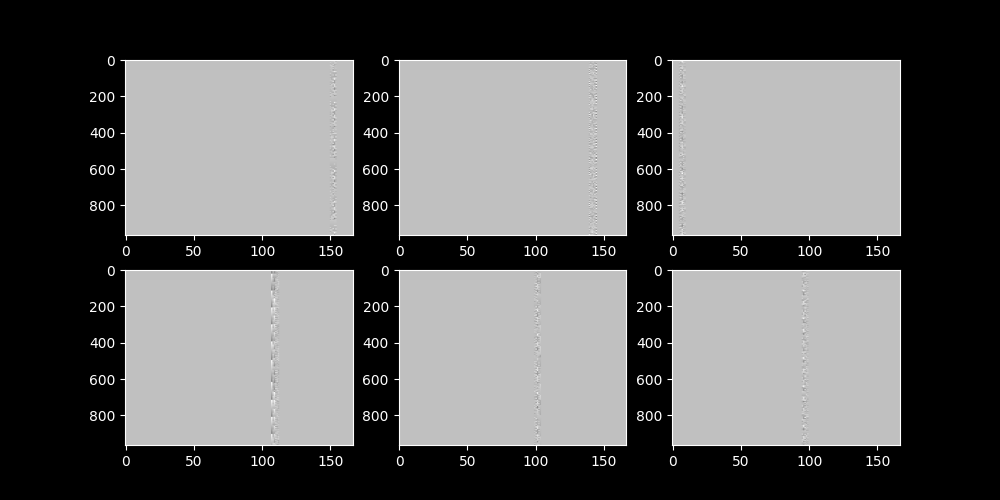

In [41]:
# %matplotlib widget
from scipy.interpolate import interp1d
map = interp1d([100, 1000], [0, 1])

class FeaturesDataSet(Dataset):
    def __init__(self, folder_path):
        # folder_path下所有文件的列表
        self.filepaths = [f'{folder_path}/{filename}' for filename in os.listdir(folder_path)]

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        # tensors = torch.load(self.filepaths[idx])
        arrays = np.load(self.filepaths[idx])
        # data = arrays['data'][0]  # shape: (3, f_len, t_len)
        data = arrays['data'][0] # shape: (3, f_len, t_len)
        data = (data + np.pi) / (2 * np.pi)  # 归一化到[0, 1]
        # data = data[:, ::10, :]
        # data = np.diff(data, axis=1)
        label = arrays['label'][:, 0]
        theta = np.deg2rad(label[1])
        label = np.array((
                np.cos(theta),
                np.sin(theta),
                # map(max(100, min(label[0], 1000)))
            )).astype(np.float32).squeeze()
        # label = np.append(label / r, map(max(100, min(r, 1000)))).astype(np.float32)
        # label = torch.tensor(np.rad2deg(np.arctan2(label[1], label[0]))) - 15
        # label = nn.functional.one_hot(label.to(torch.int64), num_classes=151).float()
        return data, label

feature = '_cpsd_phase'
ds_train = FeaturesDataSet(train_path + feature)
ds_val = FeaturesDataSet(val_path + feature)

from matplotlib.colors import Normalize
norm = Normalize(vmin=-1, vmax=1)
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(ds_train[i][0][i], aspect='auto', cmap='gray', norm=norm)
    plt.subplot(2, 3, i+4)
    plt.imshow(ds_val[i][0][i], aspect='auto', cmap='gray', norm=norm)

In [5]:
batch_size = 64
# 取样时有打乱
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=False)
dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=False)

In [8]:
# from torchviz import make_dot

# net = CNN2D(3, 167, 963)
# input = torch.tensor(ds_train[0][0]).unsqueeze(0)
# output = net(input)
# make_dot(output.mean(), params=dict(net.named_parameters()), show_attrs=True, show_saved=True).render("CNN2D_torchviz", format="png")

## 模型训练

<<<<<< ⚡️ cuda is used >>>>>>


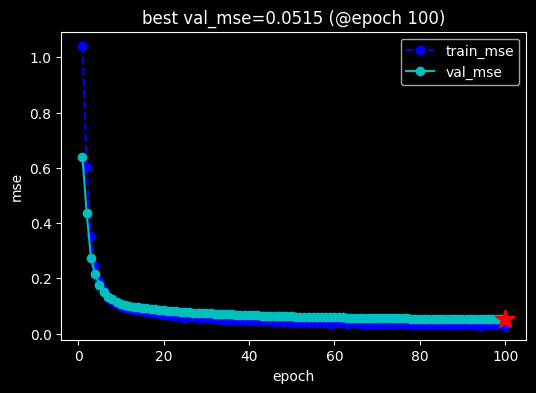

,epoch,train_loss,train_mse,lr,val_loss,val_mse
0,1,1.041624,1.041624,0.001,0.630288,0.640486
1,2,0.603654,0.603654,0.001,0.429530,0.436500
2,3,0.354721,0.354721,0.001,0.269574,0.274118
3,4,0.243525,0.243525,0.001,0.208507,0.214510
4,5,0.191242,0.191242,0.001,0.178567,0.176859
...,...,...,...,...,...,...
95,96,0.029612,0.029612,0.001,0.050224,0.051686
96,97,0.032136,0.032136,0.001,0.051019,0.051735
97,98,0.029930,0.029930,0.001,0.056483,0.052162
98,99,0.029599,0.029599,0.001,0.051287,0.051893


In [10]:
from torchkeras.kerascallbacks import WandbCallback
from argparse import Namespace

def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.normal_(m.weight)
        m.bias.data.fill_(0.0)

from torchvision.models import resnet18, ResNet18_Weights
class Predictor(nn.Module):

    def __init__(self):
        super().__init__()
        weights = ResNet18_Weights.DEFAULT
        self.resnet18 = resnet18(weights=weights)
        self.resnet18.fc = torch.nn.Linear(in_features=self.resnet18.fc.in_features, out_features=2)
        # torch.nn.init.normal_(self.resnet18.fc.weight)
        # self.resnet18.fc.bias.data.fill_(0.0)
        self.transforms = weights.transforms(antialias=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.transforms(x)
        y_pred = self.resnet18(x)
        return y_pred

net = Predictor()
# net.apply(init_weights)  # 初始化权重为全零

lr = 1e-3
optimizer=optim.SGD(net.parameters(), lr=lr)
# optimizer=optim.Adam(net.parameters(), lr=lr)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

model = KerasModel(
    net,
    # loss_fn=loss_with_regulation,
    # loss_fn=nn.L1Loss(),
    loss_fn=nn.MSELoss(),
    # loss_fn=nn.CrossEntropyLoss(),
    metrics_dict={
        # 'L1': torchmetrics.MeanAbsoluteError(),
        'mse': torchmetrics.MeanSquaredError(),
        # 'acc': Accuracy(task='multiclass', num_classes=151),
        # 'F1': torchmetrics.F1Score(task='multiclass', num_classes=151),
    },
    optimizer=optimizer,
    # lr_scheduler=lr_scheduler
)

model.fit(
    dl_train,
    dl_val,
    epochs=50,
    ckpt_path='exp/checkpoint',
    patience=5,
    monitor='val_mse',
    mode='min',
    # callbacks=[WandbCallback(project='wideband_cpsd_cnn', save_code=True, save_ckpt=True,
    #     config=Namespace(
    #         batch_size=batch_size,
    #         lr=lr,
    #     ),)
    # ]
)

In [ ]:
# 类激活映射 activation heatmap, 回归时无法分析
from torchcam.methods import LayerCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image

def show_cam():
    net.eval()
    input = torch.tensor(ds_train[np.random.randint(0, 100)][0]).unsqueeze(0)
    # initialize the Smooth Grad.CAM++ extractor
    cam_extractor = LayerCAM(net, ['conv1', 'layer1'])

    output = net(input)
    # generate the class activation map
    cams = cam_extractor(output.squeeze(0).argmax().item(), output)

    plt.figure(figsize=(30, 30))
    for i, (name, cam) in enumerate(zip(cam_extractor.target_names, cams)):
        plt.axis('off')
        plt.title(name)
        plt.subplot(1, len(cams), i+1)

        plt.imshow(cam.squeeze(0).numpy())
        # result = overlay_mask(to_pil_image(input.squeeze(0)), to_pil_image(cam.squeeze(0), mode='F'), alpha=0.1)
        # plt.imshow(result)
    plt.show()

# show_cam()

## 模型评估

标签为$(cos(\theta), sin(\theta))$

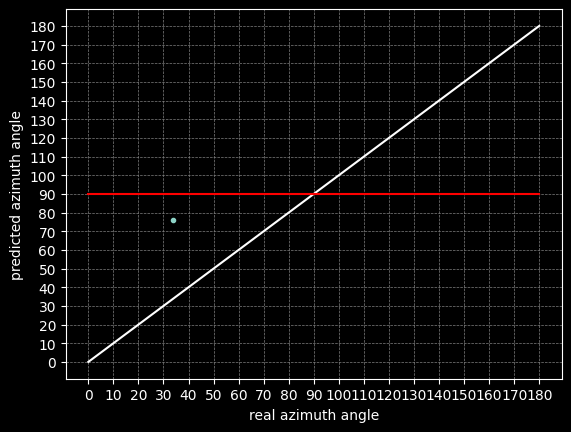

In [33]:
device = torch.device('cuda')

checkpoint_path = "./exp/checkpoint"
checkpoint = torch.load(checkpoint_path)
net.load_state_dict(checkpoint)
net.eval()
net.to(device)

data, label = FeaturesDataSet(val_path + '_phase')[np.random.randint(0, 200)]
data = torch.tensor(data).to(device)
output = net(data.unsqueeze(0))
predicted = output.detach().cpu().numpy()
# predicted_angles = np.argmax(predicted, axis=1) + 15
# label_angles = label.argmax().numpy() + 15
predicted_angles = np.rad2deg(np.arctan2(predicted[0, 1], predicted[0, 0]))
label_angles = np.rad2deg(np.arctan2(label[1], label[0]))
plt.plot(label_angles, predicted_angles, '.')
plt.plot([0, 180], [0, 180], 'white')
plt.plot([0, 180], [90, 90], 'red')

plt.xlabel('real azimuth angle')
plt.ylabel('predicted azimuth angle')
plt.xticks(np.arange(0, 190, 10))
plt.yticks(np.arange(0, 190, 10))
plt.grid(True, which='major', color='gray', linestyle='--', linewidth=0.5)

标签为$(cos(\theta), sin(\theta), r)$

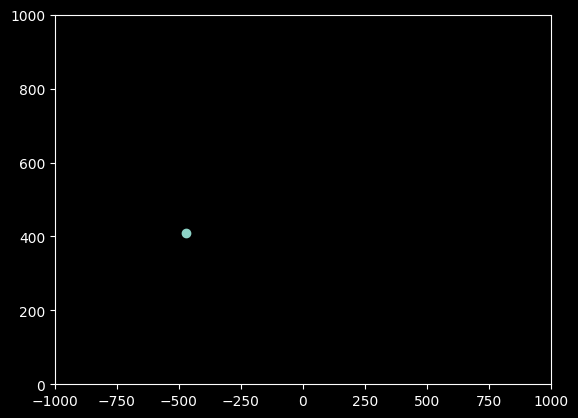

(None, array([-472.38837,  410.1409 ], dtype=float32))

In [82]:
device = torch.device('cuda')
net = model.net
net.eval()

net.to(device)
data, label = FeaturesDataSet(val_path + '_phase')[np.random.randint(0, 400)]
data = torch.tensor(data).to(device)
output = net(data.unsqueeze(0))
predicted = output.detach().cpu().numpy()
rev_map = interp1d([0, 1], [100, 1000])
predicted_coordinate = rev_map(max(0, min(predicted[0, 2], 1))) * predicted[0, :2]
label_coordinate = rev_map(max(0, min(label[2], 1))) * label[:2]
plt.plot(label_coordinate[0], label_coordinate[1], 'o')
plt.plot(predicted_coordinate[0], predicted_coordinate[1], 'o')
plt.xlim(-1000, 1000)
plt.ylim(0, 1000)
plt.show()